In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMRegressor 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

df = pd.read_csv("Housing.csv",encoding='cp1252')

# Data Cleaning

## 1. Removal of Duplicates

In [2]:
df = df.drop_duplicates()

## 2. Outlier Detection & Removal

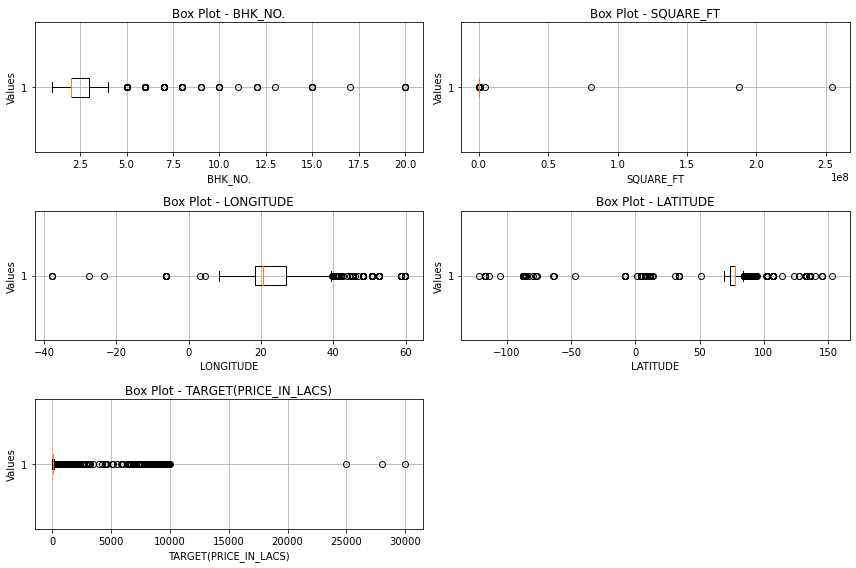

In [3]:
numerical_attributes = ['BHK_NO.', 'SQUARE_FT', 'LONGITUDE', 'LATITUDE', 'TARGET(PRICE_IN_LACS)']
# Calculate the number of rows and columns required for the grid
num_attributes = len(numerical_attributes)
num_rows = num_attributes // 2 + num_attributes % 2
num_cols = 2 if num_attributes >= 2 else 1

# Create subplots to put the box plots in the grid
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, 8))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Create a box plot for each numerical attribute
for i, attr in enumerate(numerical_attributes):
    axes[i].boxplot(df[attr], vert=False)
    axes[i].set_title(f'Box Plot - {attr}', fontsize=12)
    axes[i].set_xlabel(attr, fontsize=10)
    axes[i].set_ylabel('Values', fontsize=10)
    axes[i].grid(True)

# Hide any unused subplots
for j in range(num_attributes, num_rows * num_cols):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [4]:
# Calculate the first quartile (Q1) and third quartile (Q3) for the numerical attributes
Q1 = df[numerical_attributes].quantile(0.25)
Q3 = df[numerical_attributes].quantile(0.75)

# Calculate the interquartile range (IQR)
IQR = Q3 - Q1

# Define the outlier detection threshold
outlier_threshold = 1.5  # You can adjust this value based on your data and requirements

# Identify outliers for each numerical attribute
outliers_df = ((df[numerical_attributes] < (Q1 - outlier_threshold * IQR)) | (df[numerical_attributes] > (Q3 + outlier_threshold * IQR)))

# Print the number of outliers in each column
print(outliers_df.sum())

# Get the indices of rows that contain outliers for any numerical attribute
outlier_rows = outliers_df.any(axis=1)
# Remove the rows with outliers from the original DataFrame
df = df[~outlier_rows]
df

BHK_NO.                   283
SQUARE_FT                1612
LONGITUDE                 144
LATITUDE                 2934
TARGET(PRICE_IN_LACS)    3045
dtype: int64


,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO.,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,LONGITUDE,LATITUDE,TARGET(PRICE_IN_LACS)
0,Owner,0,0,2,BHK,1300.236407,1,1,"Ksfc Layout,Bangalore",12.969910,77.597960,55.0
1,Dealer,0,0,2,BHK,1275.000000,1,1,"Vishweshwara Nagar,Mysore",12.274538,76.644605,51.0
2,Owner,0,0,2,BHK,933.159722,1,1,"Jigani,Bangalore",12.778033,77.632191,43.0
3,Owner,0,1,2,BHK,929.921143,1,1,"Sector-1 Vaishali,Ghaziabad",28.642300,77.344500,62.5
5,Owner,0,0,3,BHK,1250.000000,1,1,"South Chittoor,Kochi",10.033280,76.282571,42.0
...,...,...,...,...,...,...,...,...,...,...,...,...
29445,Owner,0,0,2,BHK,1062.134891,1,1,"Tilakwadi,Belgaum",15.866670,74.500000,40.0
29446,Owner,0,0,3,BHK,2500.000000,1,1,"Shamshabad Road,Agra",27.140626,78.043277,45.0
29448,Dealer,0,0,2,BHK,1022.641509,1,1,"Ajmer Road,Jaipur",26.928785,75.828002,27.1
29449,Owner,0,0,2,BHK,927.079009,1,1,"Sholinganallur,Chennai",12.900150,80.227910,67.0


In [5]:
def winsorize_column(df, column, lower_percentile, upper_percentile):
    lower_bound = df[column].quantile(lower_percentile)
    upper_bound = df[column].quantile(upper_percentile)
    df[column] = df[column].clip(lower_bound, upper_bound)

attributes = ['LATITUDE', 'TARGET(PRICE_IN_LACS)', 'SQUARE_FT']

# Calculate the 1st and 99th percentiles for "Latitude" and "Target(Price_In_LACS)"
percentiles = df[attributes[:2]].quantile([0.01, 0.95])

# Apply winsorization to the first two columns
for col in attributes[:2]:
    winsorize_column(df, col, 0.01, 0.95)

# Calculate the interquartile range (IQR) for the 'SQUARE_FT' attribute
Q1 = df['SQUARE_FT'].quantile(0.25)
Q3 = df['SQUARE_FT'].quantile(0.75)
IQR = Q3 - Q1

# Apply winsorization to the 'SQUARE_FT' column
winsorize_column(df, 'SQUARE_FT', 0.05, 0.95)

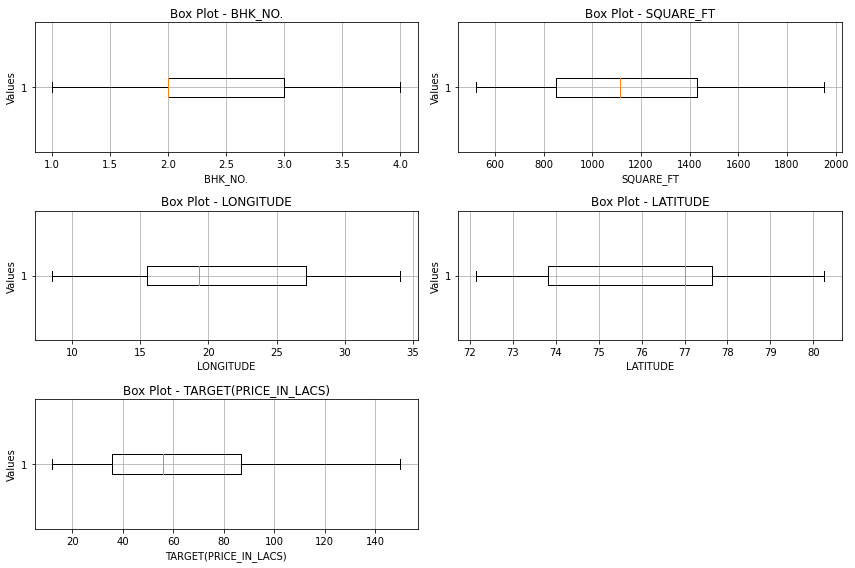

In [6]:
numerical_attributes = ['BHK_NO.', 'SQUARE_FT', 'LONGITUDE', 'LATITUDE', 'TARGET(PRICE_IN_LACS)']
# Calculate the number of rows and columns required for the grid
num_attributes = len(numerical_attributes)
num_rows = num_attributes // 2 + num_attributes % 2
num_cols = 2 if num_attributes >= 2 else 1

# Create subplots to put the box plots in the grid
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, 8))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Create a box plot for each numerical attribute
for i, attr in enumerate(numerical_attributes):
    axes[i].boxplot(df[attr], vert=False)
    axes[i].set_title(f'Box Plot - {attr}', fontsize=12)
    axes[i].set_xlabel(attr, fontsize=10)
    axes[i].set_ylabel('Values', fontsize=10)
    axes[i].grid(True)

# Hide any unused subplots
for j in range(num_attributes, num_rows * num_cols):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

# Data Transformation

In [7]:
df.drop(['POSTED_BY', 'LONGITUDE', 'LATITUDE'], axis=1, inplace=True)

In [8]:
# Applying the transformation
df['ADDRESS'] = df['ADDRESS'].str.rsplit(',', 1).str[-1]

In [9]:
 # Keep only the rows where 'ADDRESS' is 'Bangalore' and drop other rows
df = df[df['ADDRESS'].str.contains('Bangalore', case=False)]

In [10]:
df.head()

,UNDER_CONSTRUCTION,RERA,BHK_NO.,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,TARGET(PRICE_IN_LACS)
0,0,0,2,BHK,1300.236407,1,1,Bangalore,55.0
2,0,0,2,BHK,933.159722,1,1,Bangalore,43.0
8,0,1,2,BHK,1040.000000,1,1,Bangalore,41.6
11,0,0,2,BHK,1333.010179,1,1,Bangalore,110.0
12,0,0,2,BHK,927.177902,1,1,Bangalore,48.0


In [11]:
# Drop the "ADDRESS" column from the DataFrame
df.drop(columns='ADDRESS', inplace=True)

C:\Users\kayde\AppData\Local\Temp\ipykernel_28696\2135799550.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns='ADDRESS', inplace=True)


In [12]:
# Perform One-Hot Encoding
df = pd.get_dummies(df, columns=['BHK_OR_RK'])

# Visualisations

## Histogram for Distribution of House Prices

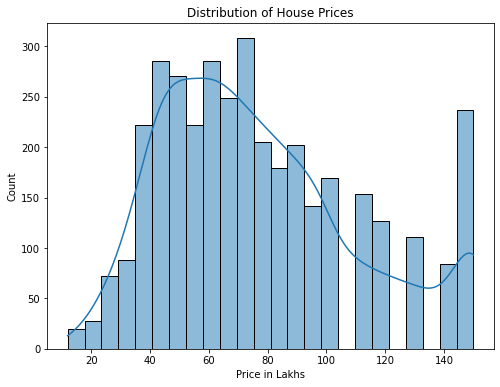

In [13]:
# 1. Histogram of Target Variable
plt.figure(figsize=(8, 6))
sns.histplot(df['TARGET(PRICE_IN_LACS)'], kde=True)
plt.xlabel('Price in Lakhs')
plt.title('Distribution of House Prices')
plt.show()

## Bar Plot for House Price by No. of Rooms

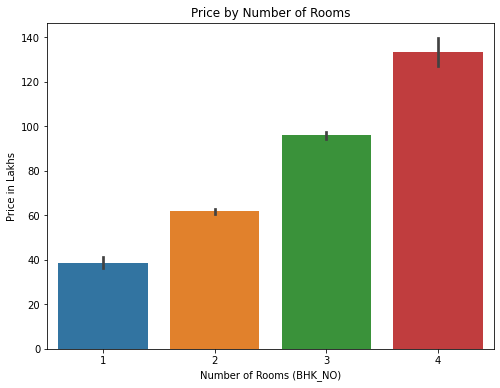

In [14]:
# 4. Bar Plot of Price by Number of Rooms (BHK_NO)
plt.figure(figsize=(8, 6))
sns.barplot(x='BHK_NO.', y='TARGET(PRICE_IN_LACS)', data=df)
plt.xlabel('Number of Rooms (BHK_NO)')
plt.ylabel('Price in Lakhs')
plt.title('Price by Number of Rooms')
plt.show()

## Box Plot of Price by Property Type

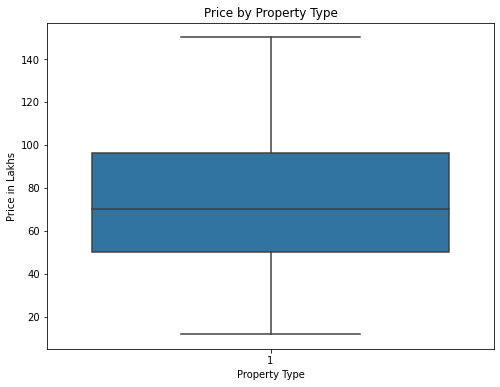

In [15]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='BHK_OR_RK_BHK', y='TARGET(PRICE_IN_LACS)', data=df)
plt.xlabel('Property Type')
plt.ylabel('Price in Lakhs')
plt.title('Price by Property Type')
plt.show()

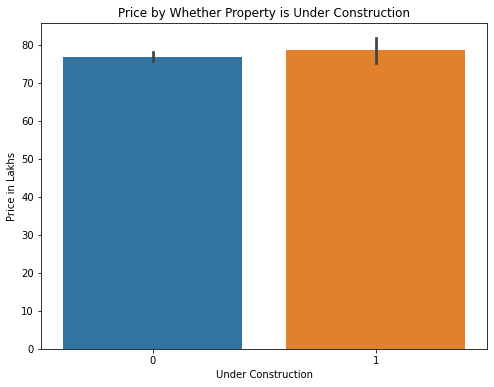

In [16]:
plt.figure(figsize=(8, 6))
sns.barplot(x='UNDER_CONSTRUCTION', y='TARGET(PRICE_IN_LACS)', data=df)
plt.xlabel('Under Construction')
plt.ylabel('Price in Lakhs')
plt.title('Price by Whether Property is Under Construction')
plt.show()

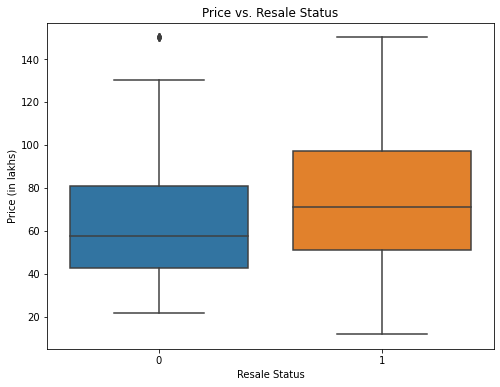

In [17]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='RESALE', y='TARGET(PRICE_IN_LACS)', data=df)
plt.title('Price vs. Resale Status')
plt.xlabel('Resale Status')
plt.ylabel('Price (in lakhs)')
plt.show()

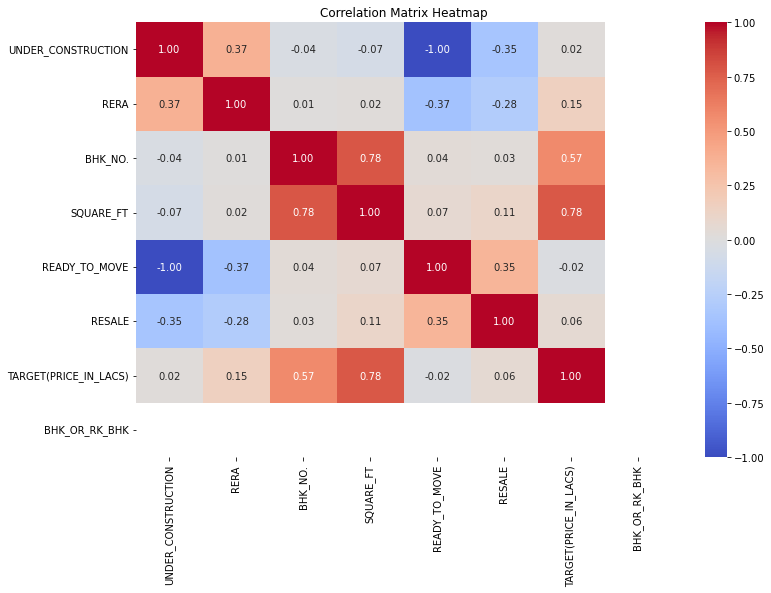

In [18]:
correlation_matrix = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()

# Data Modelling

## LightGBM

In [19]:
df

,UNDER_CONSTRUCTION,RERA,BHK_NO.,SQUARE_FT,READY_TO_MOVE,RESALE,TARGET(PRICE_IN_LACS),BHK_OR_RK_BHK
0,0,0,2,1300.236407,1,1,55.0,1
2,0,0,2,933.159722,1,1,43.0,1
8,0,1,2,1040.000000,1,1,41.6,1
11,0,0,2,1333.010179,1,1,110.0,1
12,0,0,2,927.177902,1,1,48.0,1
...,...,...,...,...,...,...,...,...
29404,0,1,2,942.269409,1,1,28.4,1
29408,0,0,2,1105.845182,1,1,42.0,1
29421,0,0,2,1409.064497,1,1,97.0,1
29433,0,0,2,1195.028681,1,1,50.0,1


In [ ]:
# Assume df contains the entire dataset, including 'TARGET(PRICE_IN_LACS)', 'SQUARE_FT', and 'BHK_NO.'

# Create a copy of the DataFrame with all features except the target variable
features_df = df.drop(columns=['TARGET(PRICE_IN_LACS)'])

# Split the data into features (X) and target variable (y)
X = features_df
y = df['TARGET(PRICE_IN_LACS)']

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Fit and transform the scaler on the data (normalizing in place)
X_train = scaler.fit_transform(X_train)

#Fit and transform the scaler on the data (normalizing in place)
X_test = scaler.fit_transform(X_test)

# Define the LightGBM model
LGBM = LGBMRegressor()

# Define hyperparameters for grid search
param_grid = {
    'n_estimators': [500, 1000, 3000],
    'max_depth': [4, 6],
    'min_child_samples': [3, 9, 17],
    'learning_rate': [0.1, 0.05, 0.02],
    'objective': ['regression_l2', 'huber'],
    'boosting_type': ['gbdt']
}

# Define the grid search we want to run. Run it with four cpus in parallel.
gs_cv = GridSearchCV(LGBM, param_grid, n_jobs=4, verbose=100)

# Run the grid search on the training data
gs_cv.fit(X_train, y_train)

# Print the best hyperparameters
print(gs_cv.best_params_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


In [ ]:
# Find the error rate on the training set using the best parameters
MAE = mean_absolute_error(y_train, gs_cv.predict(X_train))
print("Training Set Mean Absolute Error: %.4f" % MAE)

# Find the error rate on the test set using the best parameters
MAE = mean_absolute_error(y_test, gs_cv.predict(X_test))
print("Test Set Mean Absolute Error: %.4f" % MAE)

# Find the error rate on the training set using the best parameters
mse = mean_squared_error(y_train, gs_cv.predict(X_train))
print("Training Set Mean Squared Error: %.4f" % mse)

# Find the error rate on the test set using the best parameters
MSE = mean_squared_error(y_test, gs_cv.predict(X_test))
print("Test Set Mean Squared Error: %.4f" % MSE)

# Find the score on the training set using the best parameters
r2 = r2_score(y_train, gs_cv.predict(X_train))
print("R-Squared Train Score: %.4f" % r2)

# Find the error rate on the test set using the best parameters
r2 = r2_score(y_test, gs_cv.predict(X_test))
print("R-Squared Test Score: %.4f" % r2)

## Random Forest Regressor

In [26]:
# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor()

# Define hyperparameters to tune
param_grid = {
    'n_estimators': [100, 200, 300],          # Number of trees in the forest
    'min_samples_split': [2, 5, 10],          # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]             # Minimum number of samples required to be at a leaf node
}

In [27]:
# Define the grid search we want to run. Run it with four cpus in parallel.
gs_cv = GridSearchCV(rf_model, param_grid, n_jobs=4, verbose=100)
# Run the grid search - on only the training data!
gs_cv.fit(X_train, y_train)
print(gs_cv.best_params_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
{'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}


In [28]:
# Find the error rate on the training set using the best parameters
MAE = mean_absolute_error(y_train, gs_cv.predict(X_train))
print("Training Set Mean Absolute Error: %.4f" % MAE)

# Find the error rate on the test set using the best parameters
MAE = mean_absolute_error(y_test, gs_cv.predict(X_test))
print("Test Set Mean Absolute Error: %.4f" % MAE)

# Find the error rate on the training set using the best parameters
mse = mean_squared_error(y_train, gs_cv.predict(X_train))
print("Training Set Mean Squared Error: %.4f" % mse)

# Find the error rate on the test set using the best parameters
MSE = mean_squared_error(y_test, gs_cv.predict(X_test))
print("Test Set Mean Squared Error: %.4f" % MSE)

# Find the score on the training set using the best parameters
r2 = r2_score(y_train, gs_cv.predict(X_train))
print("R-Squared Train Score: %.4f" % r2)

# Find the error rate on the test set using the best parameters
r2 = r2_score(y_test, gs_cv.predict(X_test))
print("R-Squared Test Score: %.4f" % r2)

Training Set Mean Absolute Error: 12.4404
Test Set Mean Absolute Error: 15.0261
Training Set Mean Squared Error: 287.7501
Test Set Mean Squared Error: 384.4308
R-Squared Train Score: 0.7455
R-Squared Test Score: 0.6483


In [29]:
lm = LinearRegression()
lm.fit(X_train, y_train)
# Find the error rate on the training set using the best parameters
MAE = mean_absolute_error(y_train, lm.predict(X_train))
print("Training Set Mean Absolute Error: %.4f" % MAE)

# Find the error rate on the test set using the best parameters
MAE = mean_absolute_error(y_test, lm.predict(X_test))
print("Test Set Mean Absolute Error: %.4f" % MAE)

# Find the error rate on the training set using the best parameters
mse = mean_squared_error(y_train, lm.predict(X_train))
print("Training Set Mean Squared Error: %.4f" % mse)

# Find the error rate on the test set using the best parameters
mse = mean_squared_error(y_test, lm.predict(X_test))
print("Test Set Mean Squared Error: %.4f" % mse)

# Find the score on the training set using the best parameters
r2 = r2_score(y_train, lm.predict(X_train))
print("R-Squared Train Score: %.4f" % r2)

# Find the error rate on the test set using the best parameters
r2 = r2_score(y_test, lm.predict(X_test))
print("R-Squared Test Score: %.4f" % r2)

Training Set Mean Absolute Error: 15.8978
Test Set Mean Absolute Error: 15.5436
Training Set Mean Squared Error: 429.3024
Test Set Mean Squared Error: 391.6878
R-Squared Train Score: 0.6204
R-Squared Test Score: 0.6416


In [ ]:
# Save the trained model to a file
with open('trained_model.pkl', 'wb') as file:
    pickle.dump(gs_cv.best_estimator_, file)
